In [7]:
!pip install pandas numpy seaborn scikit-learn matplotlib pyspark scikit-learn-extra


# Import necessary libraries and modules
import time
import random
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from __future__ import division
import matplotlib.pyplot as plt
from numpy.linalg import norm
from sklearn.cluster import KMeans
from sklearn_extra.cluster import KMedoids  # Import KMedoids from scikit-learn-extra
from pyspark import SparkContext, SparkConf
from scipy import spatial
from numpy.linalg import norm
from sklearn import metrics

from google.colab import drive
drive.mount("/content/gdrive")

try:
    sc = SparkContext.getOrCreate()
except Exception as e:
    print("An error occurred while trying to create or get SparkContext:", str(e))
    sc = None

# If sc is still None, create a new SparkContext
if sc is None:
    conf = SparkConf().setAppName("KMedoidsClustering").setMaster("local")
    sc = SparkContext(conf=conf)

# Load data and preprocess if needed
input = "/content/gdrive/My Drive/DataSet1/Country-data.csv"
data = pd.read_csv(input)
del data['country']



Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [8]:
2+2

4

In [9]:

# Sequential K_Medoids Class
class K_Medoids(object):
    def __init__(self, n_clusters, max_iter):
        self.n_clusters = n_clusters
        self.max_iter = max_iter

    def assign_points_to_cluster(self, X):
        self.labels_ = [self._nearest(self.cluster_centers_, x) for x in X]
        indices = [np.where(np.array(self.labels_) == j)[0] for j in range(self.n_clusters)]
        X_by_cluster = [X[i] for i in indices]
        return X_by_cluster

    def initial_centroid(self, X):
        initial = np.random.permutation(X.shape[0])[:self.n_clusters]
        return X[initial]

    def fit(self, X):
        self.cluster_centers_ = self.initial_centroid(X)
        for i in range(self.max_iter):
            X_by_cluster = self.assign_points_to_cluster(X)
            new_centers = [self._choose_medoid(cluster) for cluster in X_by_cluster]
            old_centers = self.cluster_centers_
            if np.array_equal(new_centers, old_centers):
                self.number_of_iter = i
                break
            else:
                self.cluster_centers_ = new_centers
        self.number_of_iter = i
        return self

    def predict(self, X):
        return self.labels_

    def _nearest(self, medoids, x):
        return np.argmin([self._distance(x, m) for m in medoids])

    def _choose_medoid(self, cluster):
        dissimilarity = [sum(self._distance(point, other) for other in cluster) for point in cluster]
        medoid_index = np.argmin(dissimilarity)
        return cluster[medoid_index]

    def _distance(self, a, b):
        return np.sqrt(((a - b)**2).sum())

# Parallelized K_Medoids functions
def compute_centroids(points, cluster_ids):
    combined_rdd = cluster_ids.zip(points)
    sum_by_cluster_id = combined_rdd.reduceByKey(lambda x, y: np.sum([x, y], axis=0))
    count_by_cluster_id = combined_rdd.mapValues(lambda v: 1).reduceByKey(lambda x, y: x + y)
    centroids_rdd = sum_by_cluster_id.join(count_by_cluster_id).mapValues(lambda x: x[0] / x[1])
    return centroids_rdd
###############################################

def compute_medoids(points, cluster_ids):
    '''Function that returns an RDD of type (cluster_id, [medoid_coordinates])
    points: RDD of iterables (n dimensions)
    cluster_ids: RDD with the same number of samples as "points" that contains the ids of their clusters
    '''

    # Creating an RDD containing elements with the structure: (cluster_id, [point_f1, ..., point_fn])
    combined_rdd = cluster_ids.zip(points)

    # Function to compute pairwise dissimilarity between two points
    def pairwise_dissimilarity(point1, point2):
        return norm(np.array(point1) - np.array(point2))

    # Function to compute total dissimilarity for a cluster
    def total_dissimilarity(cluster_points, medoid):
        return sum(pairwise_dissimilarity(point, medoid) for point in cluster_points)

    # Function to find medoid for a cluster
    def find_medoid(cluster_points):
        min_dissimilarity = float('inf')
        medoid = None
        for point in cluster_points:
            dissimilarity = total_dissimilarity(cluster_points, point)
            if dissimilarity < min_dissimilarity:
                min_dissimilarity = dissimilarity
                medoid = point
        return medoid

    # Compute medoids for each cluster
    medoids_rdd = combined_rdd.groupByKey().mapValues(lambda points: find_medoid(list(points)))

    return medoids_rdd





def compute_distance(point_value, clusters_medoids, metric='squared_distances'):
    comp_dist = []

    if metric == 'cos_sim':
        for m in clusters_medoids:
            comp_dist.append(1 - spatial.distance.cosine(np.array(point_value), np.array(m[1])))
    else:
        for m in clusters_medoids:
            comp_dist.append(norm(np.array(point_value) - np.array(m[1])))

    return comp_dist

def assign_clusters(points, medoids, metric='squared_distances'):
    list_medoids = medoids.collect()
    list_medoidsB = sc.broadcast(list_medoids)

    distances_rdd = points.map(lambda x: compute_distance(x, list_medoidsB.value, metric))
    assign_rdd = distances_rdd.map(lambda x: np.argmin(x, axis=0))

    return assign_rdd

# def initialize_kmedoids(n_clusters, data, factor=10):
#     nb_elements = n_clusters * factor
#     sample = data.take(nb_elements)
#     medoids = []

#     for i in range(n_clusters):
#         rdn_number = random.randint(0, len(sample) - 1)
#         medoids.append([i, sample[rdn_number]])

#     return sc.parallelize(medoids)


def initialize_kmedoids(n_clusters, data, factor=10):
    nb_elements = n_clusters * factor
    sample = data.sample(False, 1.0).take(nb_elements)  # Shuffle and take a sample
    medoids = []

    for i in range(n_clusters):
        medoids.append([i, sample[i]])

    return sc.parallelize(medoids)


def custom_kmedoids(n_clusters, data, factor=15, maxIter=250, metric='squared_distances'):
    medoids = initialize_kmedoids(n_clusters, data, factor)
    stop = False
    i = 0

    while not stop and i < maxIter:
        assigned_clusters = assign_clusters(data, medoids, metric)
        new_medoids = compute_medoids(data, assigned_clusters)

        if i == 0:
            prev_medoids_ram = pd.DataFrame([x[1] for x in medoids.collect()])
        else:
            prev_medoids_ram = pd.DataFrame([x[1].tolist() for x in medoids.collect()])

        new_medoids_ram = pd.DataFrame([x[1].tolist() for x in new_medoids.collect()])

        if new_medoids_ram.equals(prev_medoids_ram):
            stop = True
        else:
            medoids = new_medoids
            i += 1

    return new_medoids, assigned_clusters

In [10]:
# Example usage
X = data.to_numpy()
t1 = time.time()
KmedoidsSer = K_Medoids(3, 2500)
y_medoids = KmedoidsSer.fit(X)
t2 = time.time() - t1
data['Label_Medoids_Seq'] = y_medoids.labels_

# Parallelized version
rdd = sc.parallelize(X)
t3 = time.time()
new_medoids, assigned_clusters = custom_kmedoids(n_clusters=3, data=rdd, maxIter=75)
t4 = time.time() - t3
data['Label_Medoids_Par'] = assigned_clusters.collect()

# Display performance metrics
print("Performance of Sequential K-medoids algorithm: ", metrics.silhouette_score(X, data['Label_Medoids_Seq']))
print("Performance of Parallel K-medoids algorithm: ", metrics.silhouette_score(X, data['Label_Medoids_Par']))




Performance of Sequential K-medoids algorithm:  0.5498575328920972
Performance of Parallel K-medoids algorithm:  0.5498575328920972


In [11]:
2 + 2

4

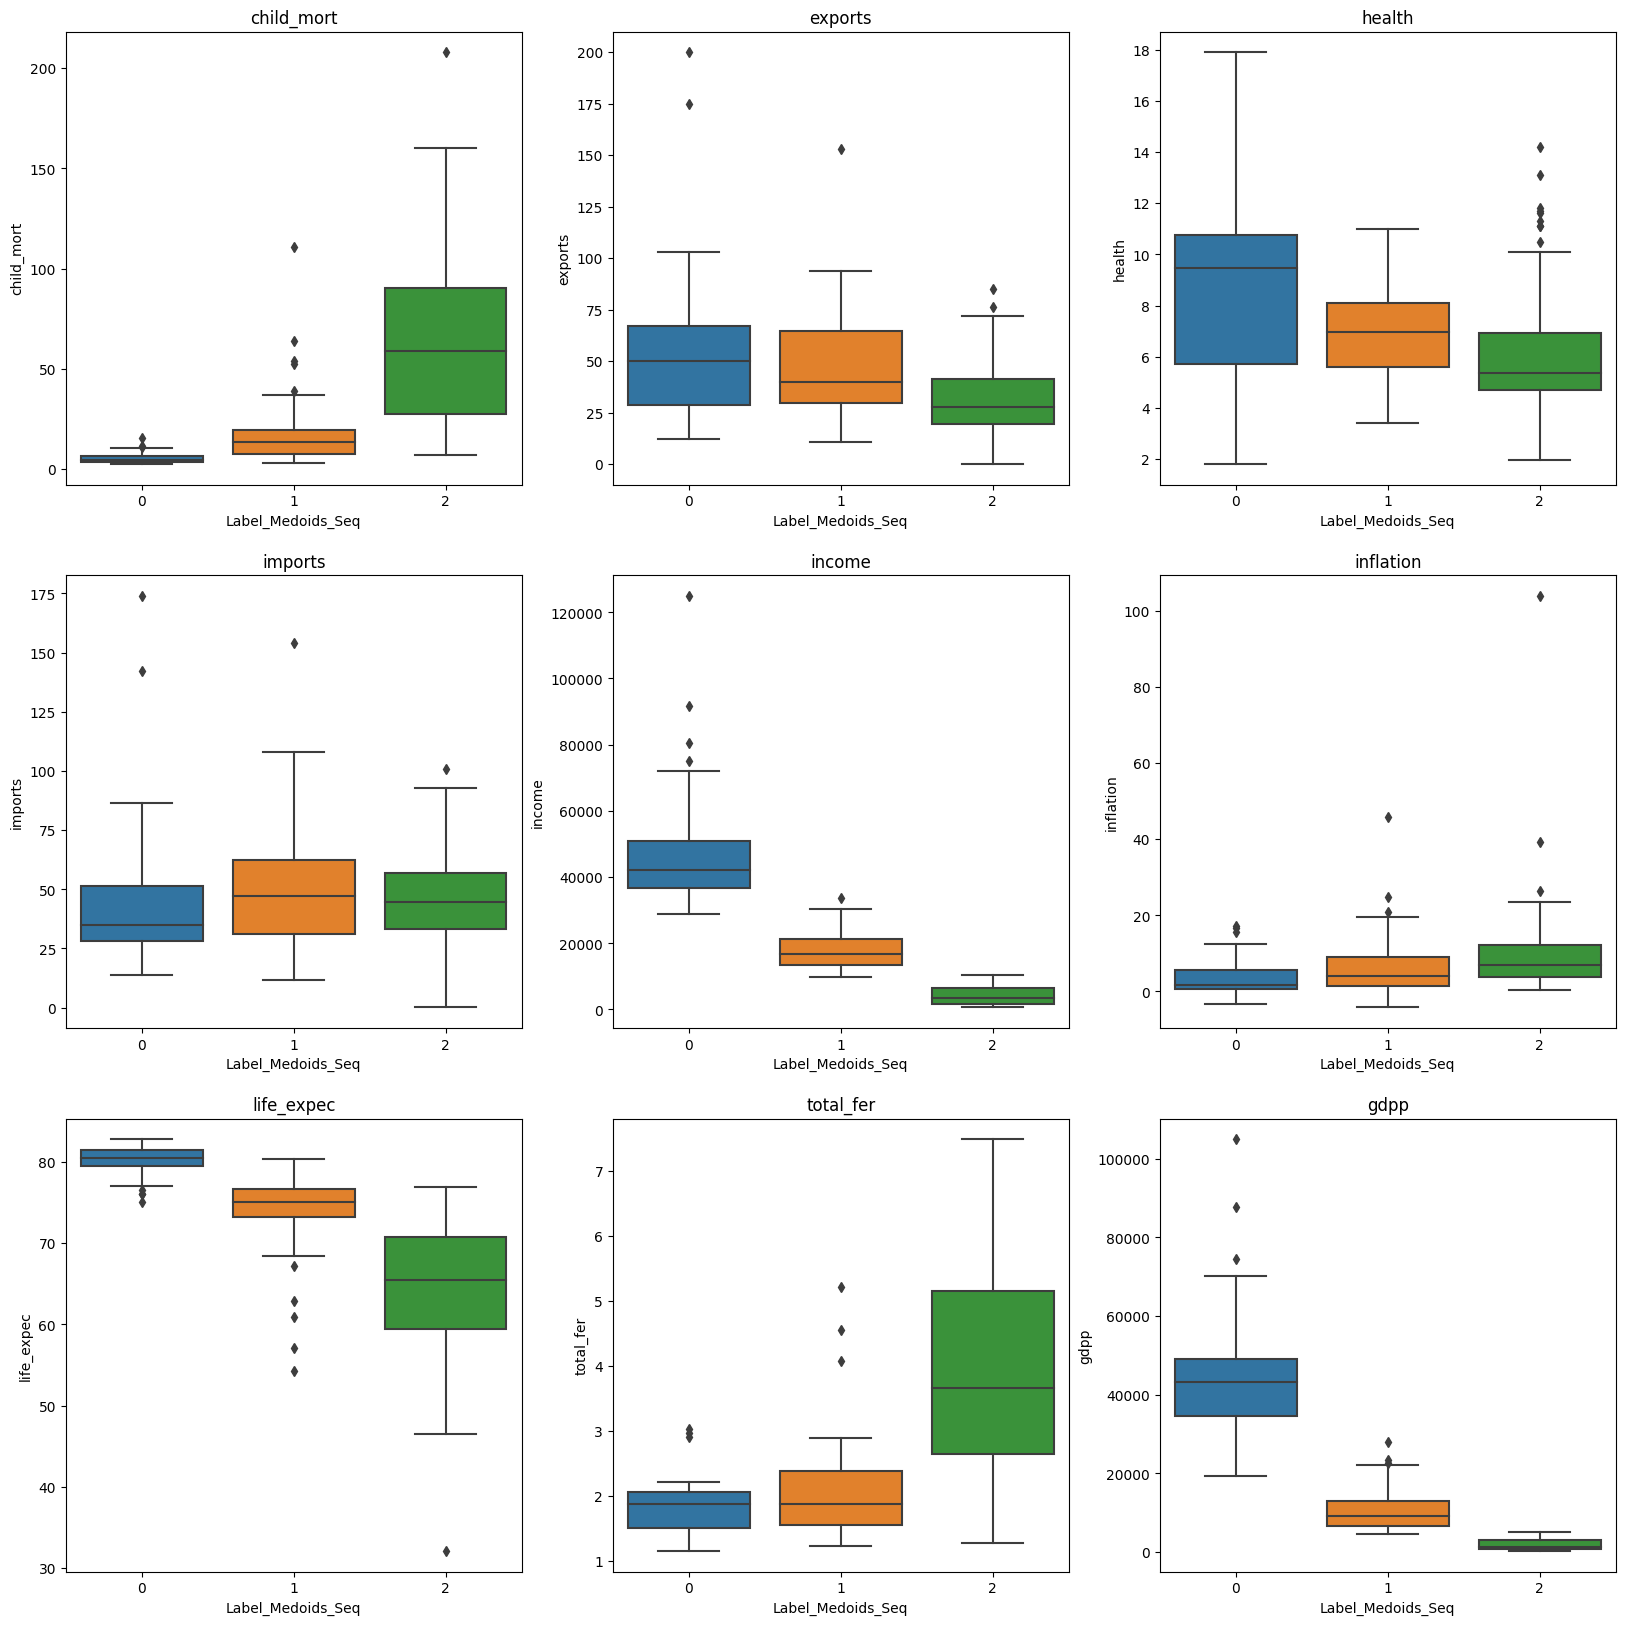

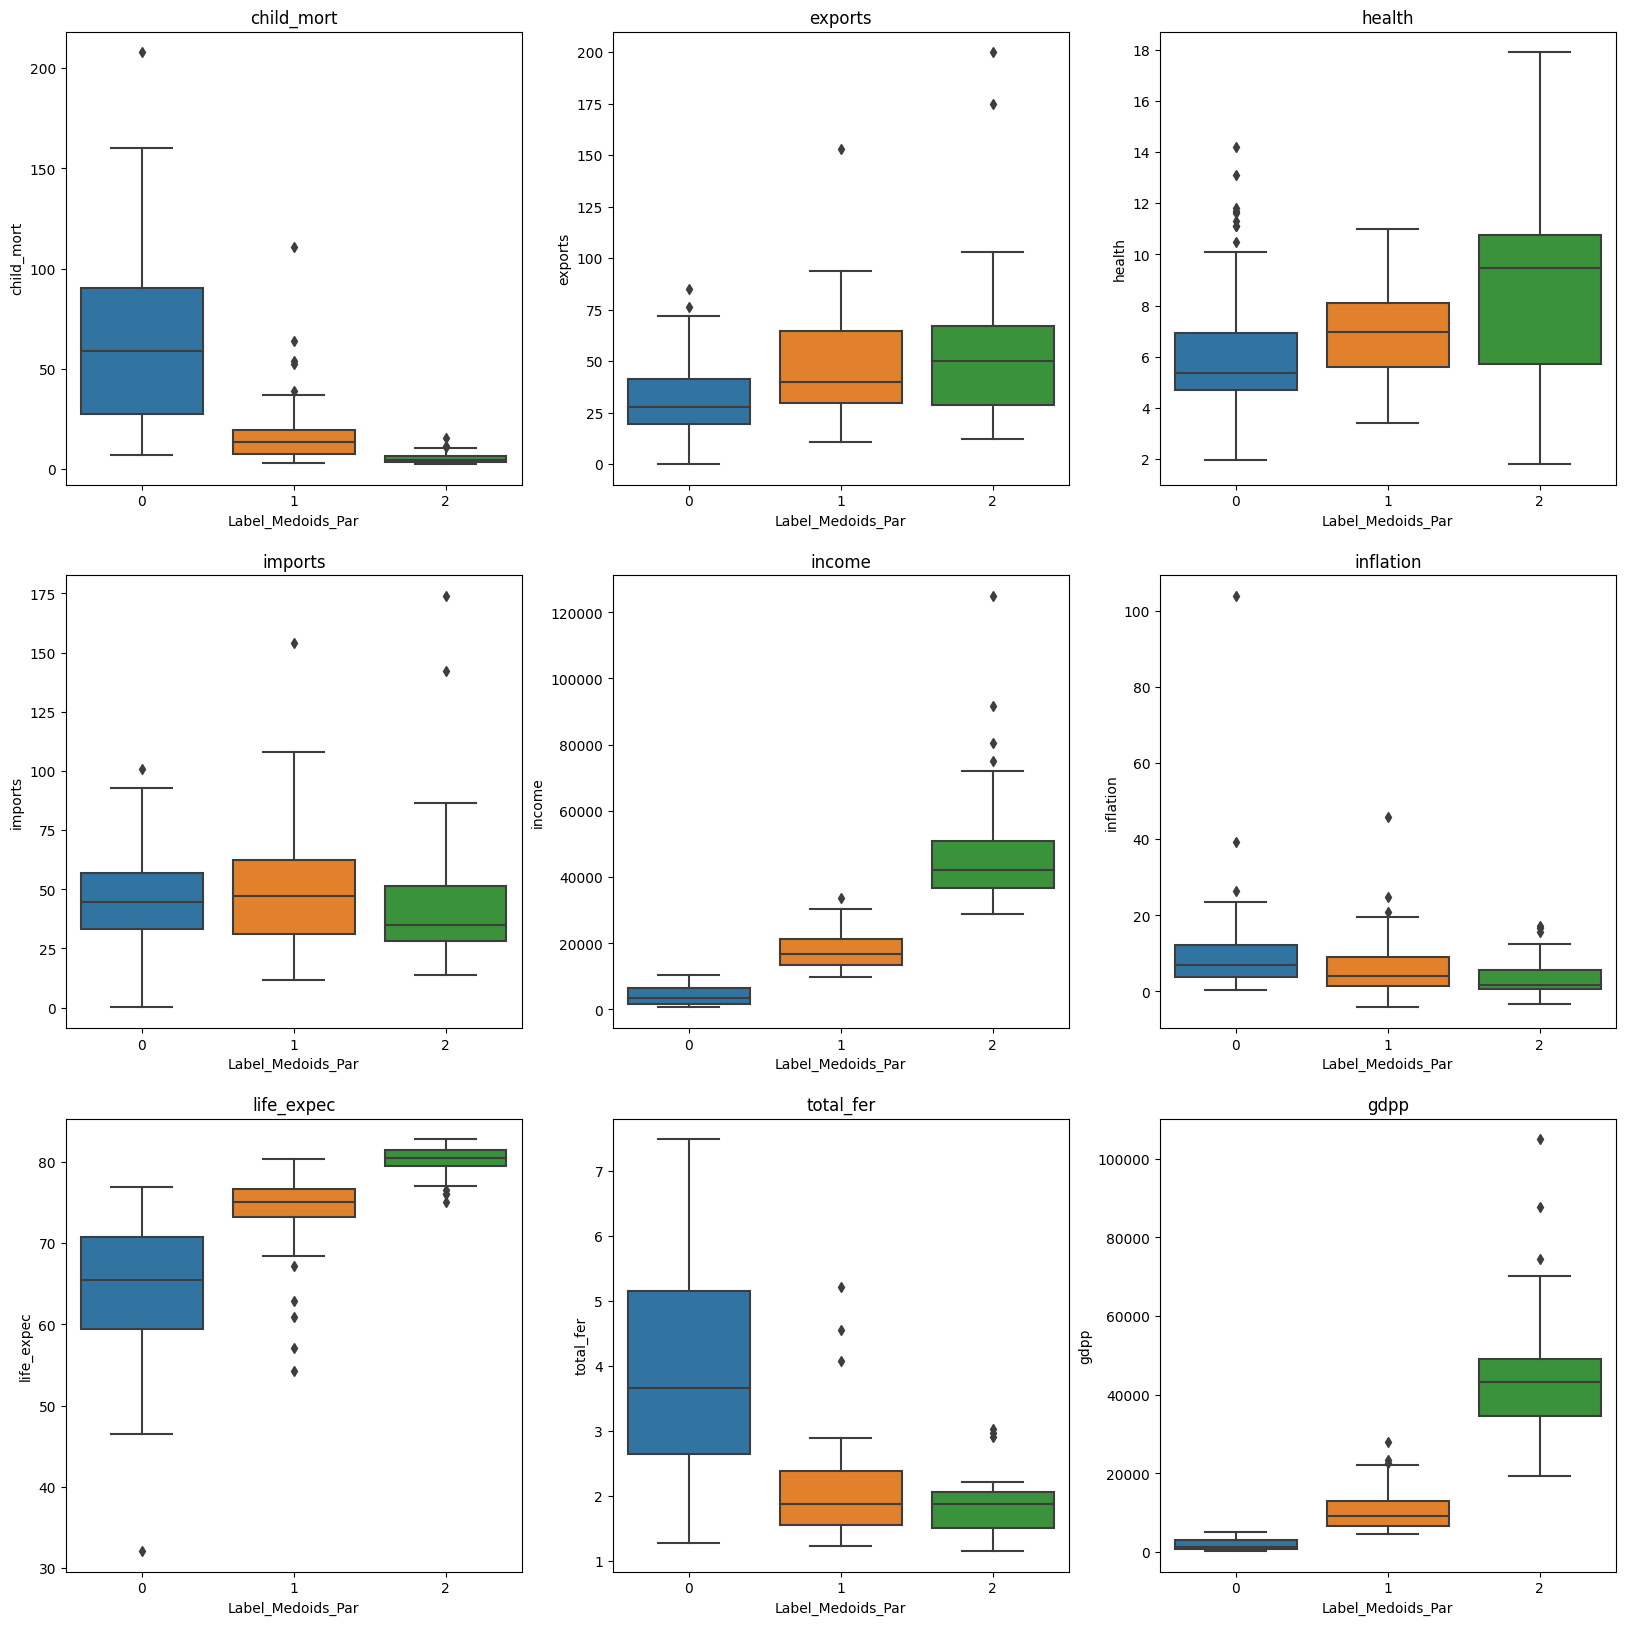

In [12]:
plt.figure(figsize=(20, 20))
for i in range(min(len(data.columns) - 1, 9)):
    plt.subplot(3, 3, i + 1)
    sns.boxplot(x=data['Label_Medoids_Seq'], y=data[data.columns[i]])
    plt.title(data.columns[i])

plt.figure(figsize=(20, 20))
for i in range(min(len(data.columns) - 1, 9)):
    plt.subplot(3, 3, i + 1)
    sns.boxplot(x=data['Label_Medoids_Par'], y=data[data.columns[i]])
    plt.title(data.columns[i])

# Show the plots
plt.show()


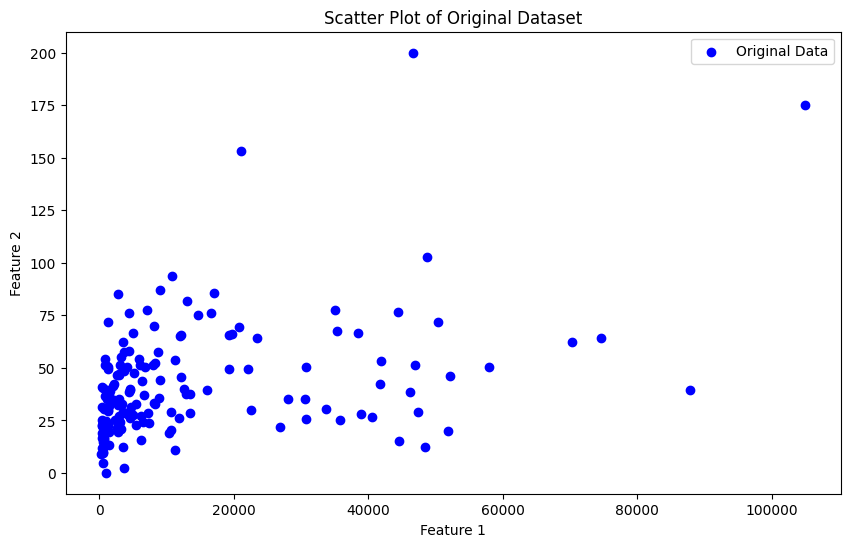

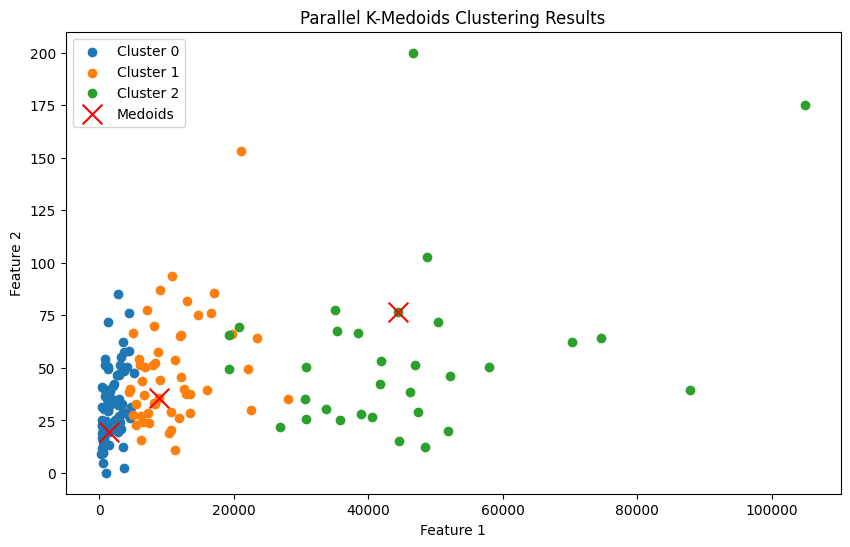

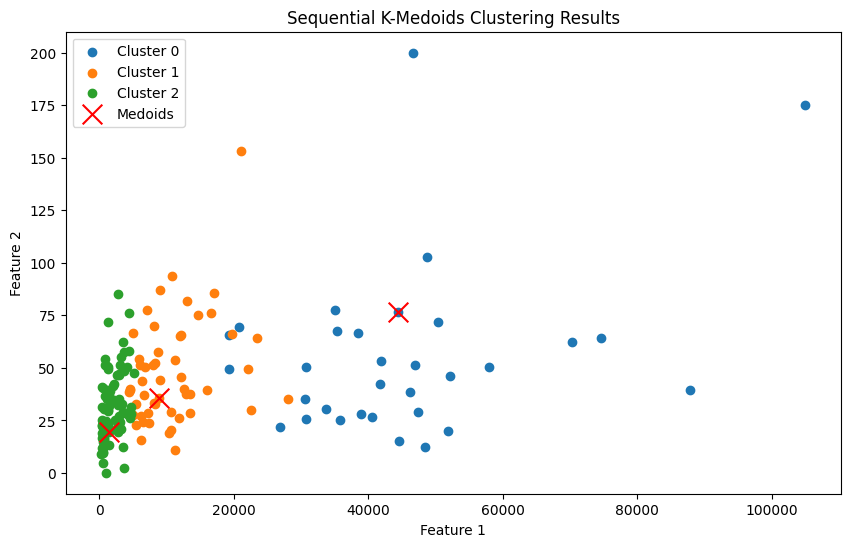

In [16]:


# Scatter plot for the original dataset
plt.figure(figsize=(10, 6))
plt.scatter(X[:, 8], X[:, 1], c='blue', marker='o', label='Original Data')
plt.title('Scatter Plot of Original Dataset')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.legend()
plt.show()


# Collect medoids data to the driver
medoids_data = new_medoids.collect()

# Extract coordinates of medoids from the list of tuples
medoids_coordinates = np.array([medoid[1] for medoid in medoids_data])

# Scatter plot for the parallel K-Medoids clustering results
plt.figure(figsize=(10, 6))
for label in np.unique(data['Label_Medoids_Par']):
    cluster_data = data[data['Label_Medoids_Par'] == label]
    plt.scatter(cluster_data.iloc[:, 8], cluster_data.iloc[:, 1], label=f'Cluster {label}')

plt.scatter(medoids_coordinates[:, 8], medoids_coordinates[:, 1], c='red', marker='x', s=200, label='Medoids')
plt.title('Parallel K-Medoids Clustering Results')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.legend()
plt.show()

# Scatter plot for the sequential K-Medoids clustering results
plt.figure(figsize=(10, 6))
for label in np.unique(data['Label_Medoids_Seq']):
    cluster_data = data[data['Label_Medoids_Seq'] == label]
    plt.scatter(cluster_data.iloc[:, 8], cluster_data.iloc[:, 1], label=f'Cluster {label}')

# Convert the cluster centers to a NumPy array
cluster_centers_seq = np.array(y_medoids.cluster_centers_)

plt.scatter(cluster_centers_seq[:, 8], cluster_centers_seq[:, 1], c='red', marker='x', s=200, label='Medoids')
plt.title('Sequential K-Medoids Clustering Results')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.legend()
plt.show()





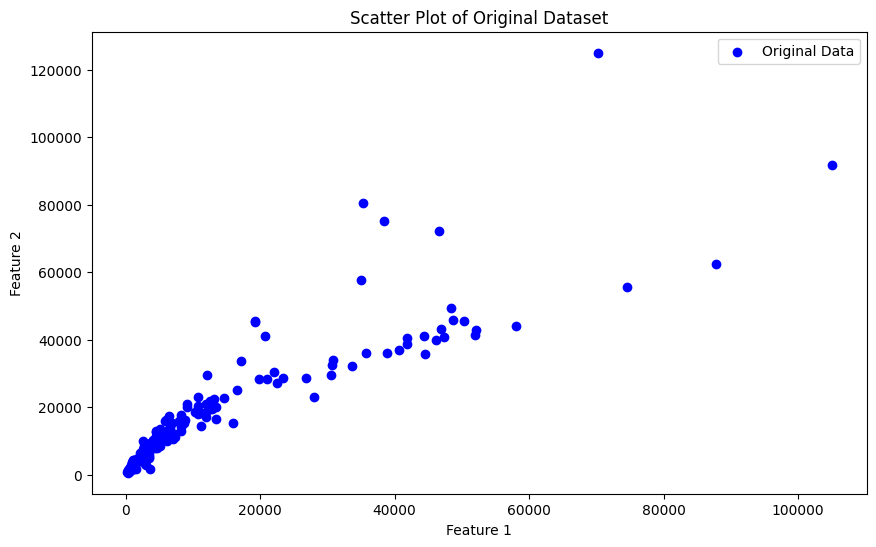

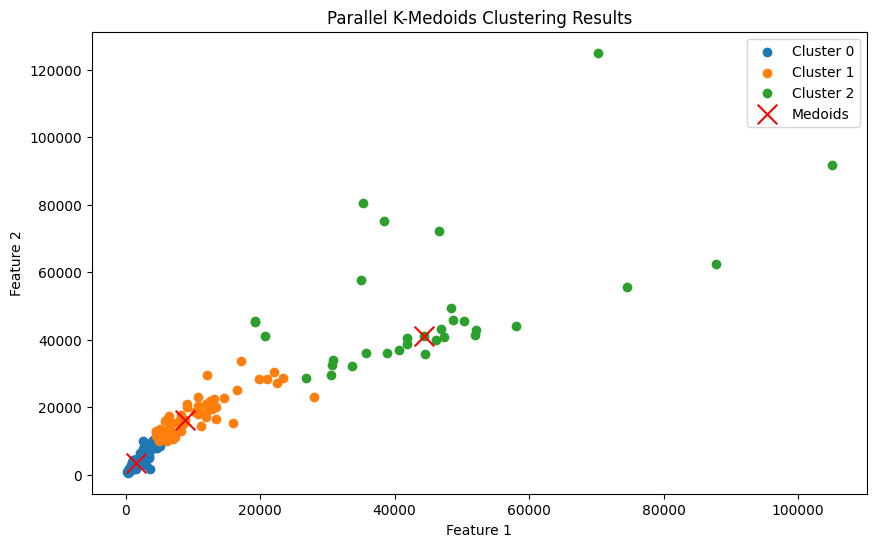

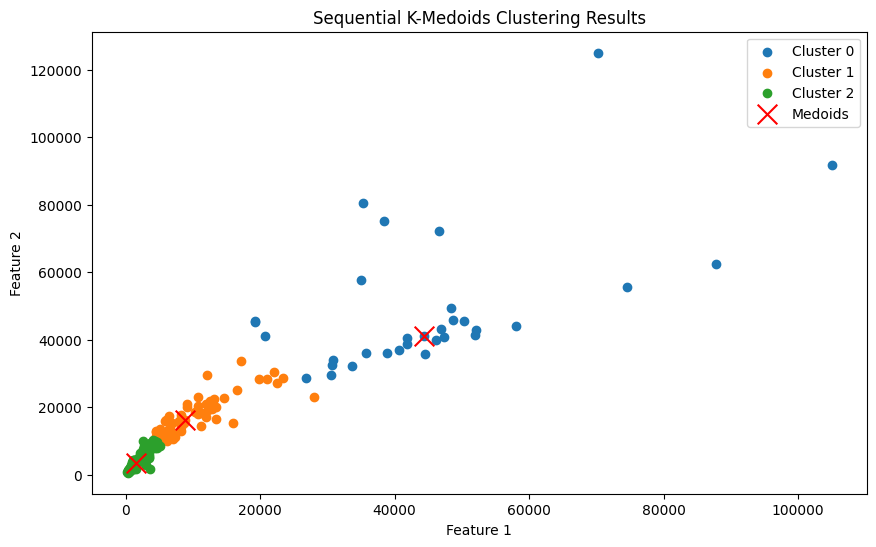

In [15]:
# Scatter plot for the original dataset
plt.figure(figsize=(10, 6))
plt.scatter(X[:, 8], X[:, 4], c='blue', marker='o', label='Original Data')
plt.title('Scatter Plot of Original Dataset')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.legend()
plt.show()


# Collect medoids data to the driver
medoids_data = new_medoids.collect()

# Extract coordinates of medoids from the list of tuples
medoids_coordinates = np.array([medoid[1] for medoid in medoids_data])

# Scatter plot for the parallel K-Medoids clustering results
plt.figure(figsize=(10, 6))
for label in np.unique(data['Label_Medoids_Par']):
    cluster_data = data[data['Label_Medoids_Par'] == label]
    plt.scatter(cluster_data.iloc[:, 8], cluster_data.iloc[:, 4], label=f'Cluster {label}')

plt.scatter(medoids_coordinates[:, 8], medoids_coordinates[:, 4], c='red', marker='x', s=200, label='Medoids')
plt.title('Parallel K-Medoids Clustering Results')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.legend()
plt.show()

# Scatter plot for the sequential K-Medoids clustering results
plt.figure(figsize=(10, 6))
for label in np.unique(data['Label_Medoids_Seq']):
    cluster_data = data[data['Label_Medoids_Seq'] == label]
    plt.scatter(cluster_data.iloc[:, 8], cluster_data.iloc[:, 4], label=f'Cluster {label}')

# Convert the cluster centers to a NumPy array
cluster_centers_seq = np.array(y_medoids.cluster_centers_)

plt.scatter(cluster_centers_seq[:, 8], cluster_centers_seq[:, 4], c='red', marker='x', s=200, label='Medoids')
plt.title('Sequential K-Medoids Clustering Results')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.legend()
plt.show()
